In [1]:
import os
import time
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
RATING_THRESHOLD = 4.0
ALPHA = 0.85
TOP_K = 10

movies = pd.read_csv("movie.csv")
ratings = pd.read_csv("rating.csv")

In [3]:
ratings = ratings.dropna(subset=['userId', 'movieId', 'rating'])
ratings['userId'] = ratings['userId'].astype(int)
ratings['movieId'] = ratings['movieId'].astype(int)
movies['movieId'] = movies['movieId'].astype(int)

ratings = ratings[ratings['rating'] >= RATING_THRESHOLD]


In [4]:

G = nx.Graph()
users = ratings['userId'].unique()
movies_in_ratings = ratings['movieId'].unique()
G.add_nodes_from(users, bipartite=0, node_type='user')
G.add_nodes_from(movies_in_ratings, bipartite=1, node_type='movie')
edges = list(zip(ratings['userId'], ratings['movieId']))
G.add_edges_from(edges)

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())


Nodes: 10873
Edges: 345658


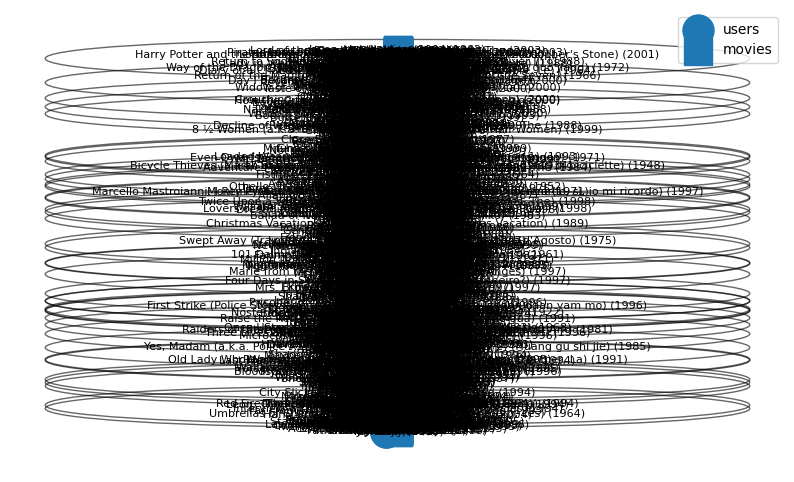

Computing global PageRank...


In [5]:
def visualize_sample(users_sample, G, movies_df):
    nodes = set(users_sample)
    for u in users_sample:
        if u in G:
            nodes.update(G.neighbors(u))
    subG = G.subgraph(nodes).copy()
    pos = {}
    user_list = [n for n in subG.nodes() if subG.nodes[n].get('bipartite') == 0]
    movie_list = [n for n in subG.nodes() if subG.nodes[n].get('bipartite') == 1]
    for i, u in enumerate(user_list):
        pos[u] = (0, i)
    for j, m in enumerate(movie_list):
        pos[m] = (2, j)
    plt.figure(figsize=(10,6))
    nx.draw_networkx_nodes(subG, pos, nodelist=user_list, node_shape='o', node_size=500, label='users')
    nx.draw_networkx_nodes(subG, pos, nodelist=movie_list, node_shape='s', node_size=400, label='movies')
    nx.draw_networkx_edges(subG, pos, alpha=0.6)
    labels = {}
    movie_title_map = movies_df.set_index('movieId')['title'].to_dict()
    for n in subG.nodes():
        if subG.nodes[n].get('bipartite') == 1:
            labels[n] = movie_title_map.get(n, str(n))
        else:
            labels[n] = str(n)
    nx.draw_networkx_labels(subG, pos, labels=labels, font_size=8)
    plt.axis('off')
    plt.legend()
    plt.show()

sample_users = list(users[:6])
visualize_sample(sample_users, G, movies)

print("Computing global PageRank...")


In [6]:
t0 = time.time()
pr = nx.pagerank(G, alpha=ALPHA)
t1 = time.time()
print("Time:", round(t1 - t0, 3), "sec")


Time: 0.992 sec


In [7]:
movie_pr = {node: score for node, score in pr.items() if node in movies_in_ratings}
top_global = sorted(movie_pr.items(), key=lambda x: x[1], reverse=True)[:TOP_K]
top_global_df = pd.DataFrame(top_global, columns=['movieId', 'pagerank_score'])
top_global_df = top_global_df.merge(movies[['movieId', 'title']], on='movieId', how='left')
print("\nTop Global Movies:")
print(top_global_df[['movieId', 'title', 'pagerank_score']].to_string(index=False))



Top Global Movies:
 movieId                                      title  pagerank_score
     741 Ghost in the Shell (Kôkaku kidôtai) (1995)        0.003132
     318           Shawshank Redemption, The (1994)        0.002452
    3284                They Might Be Giants (1971)        0.002267
     593           Silence of the Lambs, The (1991)        0.002080
     296                        Pulp Fiction (1994)        0.002057
    2762                    Sixth Sense, The (1999)        0.002012
     356                        Forrest Gump (1994)        0.001932
     156                    Blue in the Face (1995)        0.001932
    3676                          Eraserhead (1977)        0.001876
     348               Bullets Over Broadway (1994)        0.001842


In [8]:

def recommend_for_user(user_id, G, ratings_df, movies_df, k=TOP_K, alpha=ALPHA):
    liked = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique().tolist()
    if len(liked) == 0:
        print(f"User {user_id} has no liked movies.")
        return pd.DataFrame(columns=['movieId', 'title', 'score'])
    personalization = {n: 0.0 for n in G.nodes()}
    per_val = 1.0 / len(liked)
    for m in liked:
        personalization[m] = per_val
    t0 = time.time()
    pr_personal = nx.pagerank(G, alpha=alpha, personalization=personalization)
    t1 = time.time()
    movie_scores = {n: s for n, s in pr_personal.items() if n in movies_in_ratings and n not in liked}
    topk = sorted(movie_scores.items(), key=lambda x: x[1], reverse=True)[:k]
    df = pd.DataFrame(topk, columns=['movieId', 'score'])
    df = df.merge(movies_df[['movieId', 'title']], on='movieId', how='left')
    print(f"Time for personalized PageRank: {round(t1 - t0,3)} sec")
    return df

test_user = 1 if 1 in users else users[0]
print(f"\nRecommendations for user {test_user}:")
personalized_recs = recommend_for_user(test_user, G, ratings, movies)
print(personalized_recs[['movieId', 'title', 'score']].to_string(index=False))


Recommendations for user 1:
Time for personalized PageRank: 0.66 sec
 movieId                                             title    score
       1                                  Toy Story (1995) 0.004614
     593                  Silence of the Lambs, The (1991) 0.001998
     356                               Forrest Gump (1994) 0.001781
     156                           Blue in the Face (1995) 0.001669
    2571                                Matrix, The (1999) 0.001639
      50                        Usual Suspects, The (1995) 0.001623
     741        Ghost in the Shell (Kôkaku kidôtai) (1995) 0.001591
     527                           Schindler's List (1993) 0.001485
     110                                 Braveheart (1995) 0.001482
    1210 Star Wars: Episode VI - Return of the Jedi (1983) 0.001463
